<a href="https://www.kaggle.com/code/alnwsany/weather-today?scriptVersionId=178202778" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# what the weather today .... question you ask everyday

# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Table of Contents 💼 🗝️</p>



<div style = 'border : 3px solid lightblue; background-color:#4C8BF5;padding:10px'>


* **[1.Introduction 📜](#1)**

  - A simple definition of the idea of ​​the project
    
    
* **[2.Importing libraries 📚](#2)**  

   - Recall the most important libraries through which the project is completed 
    
 
* **[3.Exploratory data analysis (EDA) 📊](#3)**  

    - Knowledge of information through data and its representation in graphs

    - Know the parts that are not clear in the data in its normal form
      
    
* **[4.Data preprocessing 🔧](#4)**  
    
   - Data splitting 
    
   - Data generators 

    
* **[5.model Arch](#5)**  
    - Training the model
    
    - plotting the model
    
* **[6.model](#6)**  
    
    - Training the model
    
    
* **[7.Model evaluation 📈](#7)**  
   
    - Classification report
    
    - Confusion matrix
    
    
 * **[8.Predict](#8)**
    
    - predict the temp 
   
    

<a id="1"></a>
<p style="padding:10px;background-color:#4C8BF5;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Introduction</p>


This notebook presents a time series analysis and forecasting model for daily minimum temperatures. The model uses a Convolutional Neural Network (CNN) and Long Short-Term Memory (LSTM) layers to predict future temperatures.


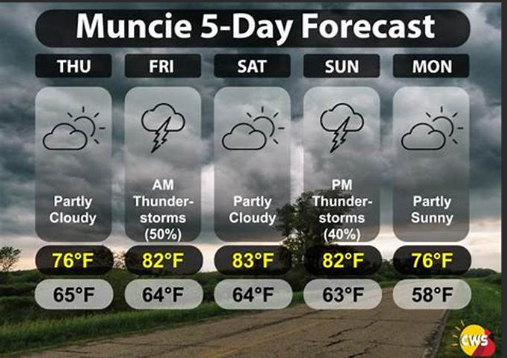

<a id="2"></a>
<p style="padding:10px;background-color:#4C8BF5;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Importing libraries 📚</p>


In [1]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

2024-05-17 12:26:27.672055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-17 12:26:27.672199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-17 12:26:27.807660: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a id="3"></a>
<p style="padding:10px;background-color:#4FA8D3;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Exploratory data analysis (EDA) 📊</p>


In [2]:
TEMPERATURES_CSV = '/kaggle/input/temperatures/daily-min-temperatures.csv'

with open(TEMPERATURES_CSV, 'r') as csvfile:
    print(f"Header looks like this:\n\n{csvfile.readline()}")    
    print(f"First data point looks like this:\n\n{csvfile.readline()}")
    print(f"Second data point looks like this:\n\n{csvfile.readline()}")

Header looks like this:

"Date","Temp"

First data point looks like this:

"1981-01-01",20.7

Second data point looks like this:

"1981-01-02",17.9



In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

<a id="4"></a>
# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Data preprocessing 🔧 </p>

In [4]:
def parse_data_from_file(filename):
    
    times = []
    temperatures = []

    
    with open(filename) as csvfile:

        reader = csv.reader(csvfile, delimiter=',')
        next(reader)  # Skip the header row
        for row in reader:
            times.append(row[0])
            temperatures.append(float(row[1]))
  
            
    return times, temperatures

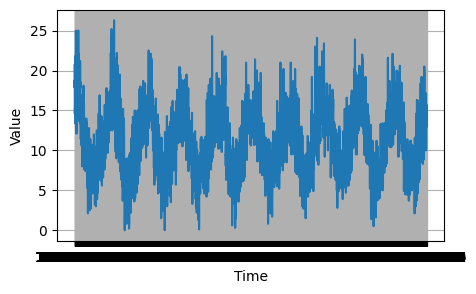

In [5]:
@dataclass
class G:
    TEMPERATURES_CSV = '/kaggle/input/temperatures/daily-min-temperatures.csv'
    times, temperatures = parse_data_from_file(TEMPERATURES_CSV)
    TIME = np.array(times)
    SERIES = np.array(temperatures)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 64
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000


plt.figure(figsize=(5,3))
plot_series(G.TIME, G.SERIES)
plt.show()

In [6]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [7]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds




In [8]:
train_set = windowed_dataset(series_train,
                             window_size=G.WINDOW_SIZE,
                             batch_size=G.BATCH_SIZE, 
                             shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

<a id="5"></a>
# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500"> Model Archeiture </p>

In [9]:
def create_uncompiled_model():

    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Conv1D(64, 3, padding='causal', activation='relu', input_shape=[G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    return model

In [10]:

uncompiled_model = create_uncompiled_model()


for X, y in train_set.take(1):
    
    # Generate a prediction
    print(f'Testing model prediction with input of shape {X.shape}...')
    y_pred = uncompiled_model.predict(X)
    

y_pred_shape = y_pred.squeeze().shape

assert y_pred_shape == y.shape, (f'Squeezed predicted y shape = {y_pred_shape} '
                                           f'whereas actual y shape = {y.shape}.')

print("Your current architecture is compatible with the windowed dataset! :)")

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Testing model prediction with input of shape (32, 64)...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Your current architecture is compatible with the windowed dataset! :)


<a id="6"></a>
# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Model</p>

In [11]:
def create_model():

    model = create_uncompiled_model()

    model.compile(loss='huber',
                  optimizer='adam',
                  metrics=["mae"])  
    return model

In [12]:
model = create_model()

history = model.fit(train_set, epochs=50)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 6.3134 - mae: 6.8021
Epoch 2/50
 1/77 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - loss: 3.0009 - mae: 3.4762

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6105 - mae: 3.0734
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.8304 - mae: 2.2808
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7348 - mae: 2.1817
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5667 - mae: 2.0154
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5285 - mae: 1.9682
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5488 - mae: 1.9901
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.5398 - mae: 1.9811
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5089 - mae: 1.9545
Epoch 10/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5095 - mae: 1.9511
Epoch 11/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5940 - mae: 2.0411
Epoch 12/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.4962 - mae: 1.9330
Epoch 13/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.5143 - mae: 1.9499
Epoch 14/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/

<a id="6"></a>
# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Forcasting </p>


In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


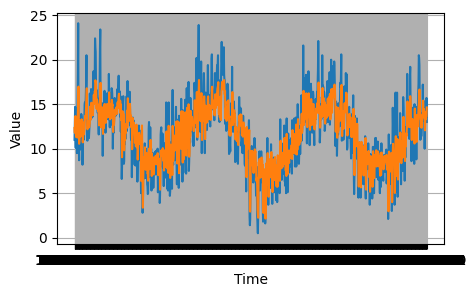

In [14]:
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(5, 3))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

<a id="7"></a>
# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Evaluation </p>


In [15]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

mse, mae = compute_metrics(series_valid, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")



mse: 5.27, mae: 1.80 for forecast


<a id="8"></a>
# <p style="padding:10px;background-color:#8DA48E ;margin:0;color:white;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:500">Prediction for a Specific Date </p>

In [16]:
def predict_temperature(model, series, window_size, date):
    # Prepare the input data for prediction
    input_data = series[-window_size:]  # Use the most recent window of data
    input_data = np.expand_dims(input_data, axis=0)  # Add batch dimension
    # Generate prediction
    forecast = model.predict(input_data).flatten()
    # Return the forecasted temperature for the given date
    return forecast[0]



In [17]:
date_to_predict = '2024-03-05'  # Date to predict temperature for
forecasted_temperature = predict_temperature(model, G.SERIES, G.WINDOW_SIZE, date_to_predict)
print(f"The forecasted temperature for {date_to_predict} is {forecasted_temperature:.2f} degrees Celsius.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
The forecasted temperature for 2024-03-05 is 13.34 degrees Celsius.
